Alex Medina | ASTRGU4260 - Final Project

In [3]:
#General Imports
import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
#Constants the will be used throughout equations(in SI Units);
G     = 6.67e-11                 #Gravitation constant
c     = 3e8                      #Speed of light
me    = 9.11e-31                 #Electron mass
mp    = 1.67e-27                 #Proton mass
hbar  = 1.05e-34                 #Reduced Planck constant = h/2*pi
kb    = 1.381e-23                #Boltzmann constant
sbc   = 5.67e-8                  #Stefan-Boltzmann constant
gamma = 5.0/3.0                  #Adiabatic constant for convective heat transfer
arad  = (4.0*sbc)/c              #Radiation constant

X = 0.7                          #Hydrogen mass fraction
Y = 0.28                         #Helium mass fraction
Z = 0.02                         #Metals mass fraction
mu = (2.0 * X + 0.75 * Y + 0.5 * Z)**-1.0    #Mean molecular weight(assuming a 100% ionized sun)

#Constants for a sample star(to normalize); all values of the sun
rho_c = 1.5e5                  #Central density
T_c   = 1.5e7                  #Central temperature
M_sun = 1.989e30
R_sun = 6.96e8
L_sun = 3.85e26

Creating a class as the bulk of the model(regularly modulation took 1h to run but unsuccessfully)(All resources used in paper)

In [5]:
#Creating a class(explained in paper the purpose); will contain most of the work
class Hydrostatic_STAR:
#______________________________________________PART 1: INITIALIZATION______________________________________________
    def __init__(self, dr, rho_central, temp_central):
        #dr is the step size
        self.dr            = dr
        self.dPdrho_values = np.zeros(3)
        self.dPdT_values   = np.zeros(3)
        self.a             = 0.0
        
        #Like in in Pset4; we have to define central point arrays
        self.radius        = [10.0] #Start with small radius
        self.density       = [rho_central]
        self.temperature   = [temp_central]
        self.mass          = [(4.0/3.0) * math.pi * self.radius[0]**3.0 * self.density[0]]
        #Example of why class is necessary - epsilon value;
        self.luminosity    = [(4.0/3.0) * math.pi * self.radius[0]**3.0 * self.density[0] * self.epsilon(self.density[0], self.temperature[0])]
        self.opacity       = [self.kappa(self.density[0], self.temperature[0])]
        self.pressure      = [self.Pressure(self.density[0], self.temperature[0])]
        self.tau           = [self.kappa(self.density[0], self.temperature[0]) * self.density[0]]
        
        #Loops through RK4 until condition is met;
        self.Generate()
        self.a = self.surface_radi()



#______________________________________________PART 2: PARAMETERS______________________________________________
#Specific parameters for the funtions;
    #Opacity parameter for radiative energy transfer;
    #Kappa paramter of opacity;
    def kappa(self, rho, temp):
        #Opacity from electron scattering
        k_es = 0.02 * (1 + X)

        #Kappa for free-free absoprtion;
        k_ff = 1.0e24 * (Z / 0.0001) * (1.0 + X) * ((rho * 1.0e-3)**0.7) * (temp ** (-3.5))

        #Kappa for bound-free absorption;
        k_bf = 2.5e-32 * (Z / 0.02) * ((rho * 1e-3)**0.5) * (temp**9.0)
        
        return 1.0 / (1.0 / k_bf + 1.0) + (np.max([k_ff, k_es]))


    #Rate of energy production paramter: Epsilon(for differntial luminosity);Energy-production equations (epsilon):
    def epsilon(self, rho, temp):
        #Epsilon for the PP type reactions, e is proportional to T**4
        e_PP = 1.07e-7 *(rho / 1.0e5) * (X**2.0) * ((temp/1.0e6)**4.0)

        #Epsilon for the CNO cycle stars, e is proportional to T**20
        e_CNO = 8.24e-26 * (rho / 1.0e5) * (0.03 * X**2.0) * ((temp / 1.0e6)**20.0)

        return e_PP + e_CNO   



#______________________________________________PART 3: EQUATIONS______________________________________________
#Solving the Diff EQ's is easier using differential rho values rathere than differential pressure(as pressure is a summation);
    def Pressure(self, rho, temp):
        #Degeneracy pressure
        P_degen = ( (3.0 * math.pi**2.0)**(2.0 / 3.0) / 5.0) * ((hbar**2.0) / me) * (rho / mp) ** (5.0 / 3.0)                  
    
        #Pressure for ideal gas
        P_ideal = rho * (kb * temp) / mu                                                          

        #Radiative pressure
        P_rad = (1.0 / 3.0) * arad * temp**4.0                                                      
    
        return P_degen + P_ideal + P_rad

    #Differential pressure(w.r.t rho)[notice, only include degen and ideal DE's];
    def dPdrho(self, rho, temp):
        #Differential degeneracy pressure
        dpdrho_degen = (((3 * math.pi ** 2) ** (2 / 3.0)) / 3.0) * ((hbar ** 2) / (me * mp)) * (rho / mp) ** (2 / 3.0)
    
        #Differential ideal gas pressure
        dPdrho_ideal = kb * temp / mu
    
        return dpdrho_degen + dPdrho_ideal

    #Also need differential pressure(w.r.t temp)[for radiative pressure];
    def dPdT(self, rho, temp):
        #Differential ideal gas pressure(w.r.t temp)
        dPdT_ideal = rho * kb / mu

        #Differential radiative pressure
        dPdT_radi  = (4.0 / 3.0) * arad * (temp**3.0)

        return dPdT_ideal + (4.0 / 3.0) * dPdT_radi

    #Here are the primary coupled diff-eqs that will be intgrated;
    #Differential mass;
    def dMdr(self, rho, radi):
        return 4.0 * math.pi * radi**2.0 * rho                                                

    #Differential luminosity;
    def dLdr(self, rho, temp, radi):
        return 4.0 * math.pi * radi**2.0 * rho * self.epsilon(rho, temp)                      

    #Differential temperture;
    def dTdr(self, rho, temp, radi, mass, lumi):
        #Radiative energy transfer
        t_rad = 3.0 * self.kappa(rho, temp) * rho * lumi / (64.0 * math.pi * sbc * (temp ** 3.0) * (radi ** 2.0))                         
    
        #Convective heat transer;
        pressure_c = self.Pressure(rho, temp)
        t_con = (1.0 - 1.0 / gamma) * (temp / pressure_c) * (G * mass * rho / radi ** 2.0)
    
        #Rather than using an if/and statement, we can just do it to choose the minimum of the two values calculated
        return - np.min([t_rad, t_con])

    #Differential density;
    def drhodr(self, rho, temp, radi, mass, lumi):
        return -((G * mass * rho / (radi ** 2.0)) + self.dPdT(rho, temp) * self.dTdr(rho, temp, radi, mass, lumi)) / self.dPdrho(rho, temp)

    #Differential for optical depth; this is particularly useful as a boundary condtion
    def dtaudr(self, rho, temp):
        return rho * self.kappa(rho, temp)   



#______________________________________________PART 4: Integrator routine______________________________________________
    def RK4(self, funcs, s, r, h):
        #funcs are the functions used
        #s are the dependent variables(where s[0] is a different paramter than s[1])
        #r is the radius, independent variable
        #h = stepsize || self.dr above
        #based on solution in pset4

        k1 = h * funcs(s           , r)
        k2 = h * funcs(s + 0.5 * k1, r + 0.5 * h)
        k3 = h * funcs(s + 0.5 * k2, r + 0.5 * h)
        k4 = h * funcs(s + k3      , r + h)

        return s + (k1 + 2.0 * (k2 + k3) + k4)/6.0, r + h

    def funcs(self, dep_vars, r):
        #dep_vars are just the parameters
        rho  = dep_vars[0]
        temp = dep_vars[1] 
        mass = dep_vars[2]
        lumi = dep_vars[3]
        radi = r
        
        rho_func  = self.drhodr(rho, temp, radi, mass, lumi)
        temp_func = self.dTdr  (rho, temp, radi, mass, lumi)
        mass_func = self.dMdr  (rho, radi)
        lumi_func = self.dLdr  (rho, temp, radi)
        tau_func  = self.dtaudr(rho, temp)
        return np.array([rho_func, temp_func, mass_func, lumi_func, tau_func],float)

    def update_vals(self, rk4_output, r_new):
        self.density.append    (rk4_output[0])
        self.temperature.append(rk4_output[1])
        self.mass.append       (rk4_output[2])
        self.luminosity.append (rk4_output[3])
        self.pressure.append(self.Pressure(self.density[-1], self.temperature[-1]))
        self.opacity.append (self.kappa(self.density[-1], self.temperature[-1]))
        self.radius.append  (r_new)

    
    #Check boundary condition; the equivalent of checking for negative pressure;
    def opacity_bdy(self):
        dtau = self.kappa(self.density[-1], self.temperature[-1]) * self.density[-1]**2 / abs(self.drhodr(self.density[-1], self.temperature[-1], self.radius[-1], self.mass[-1], self.luminosity[-1]))
        
        if dtau < 0.0 or math.isnan(dtau): #Not a number
            opacitybdy = True
        else:
            opacitybdy = False
        
        if self.radius[-1] > 1.0e10: opacitybdy = True #So that it doesn't integrate forever
        
        return opacitybdy

    #To find the radius at which the opacity condition is met;
    def surface_radi(self):
        self.a = np.argmin(abs(self.tau[-1] - np.array(self.tau) - (2.0/3.0)))
        if self.tau[self.a] == 0:
            self.a = len(self.tau) - 1
        return self.a



#______________________________________________PART 5: Integrator routine continued(adaptive method)______________________________________________
    def RK4_steps(self, funcs, s, r, h):
        rho_error  = 0.0
        increase_step = True
        step_max   = 0.001 * R_sun #Max step size will be 0.001 of the suns radius
        
        
        while rho_error <= 1.0:
            s1, r_new1  = self.RK4(funcs, s , r          , self.dr)
            s2, r_new2  = self.RK4(funcs, s1, r + self.dr, self.dr)
            s3, r_nnew3 = self.RK4(funcs, s , r          , 2.*self.dr)

            #Surface accuracy
            top       = self.dr * 1.0e14
            bottom    = np.sqrt(np.sum(np.power((s3 - s2), 2.0)))
            rho_error = top / bottom
            
            #If temp is getting close to the surface, change step_max
            if self.temperature[-1]/self.temperature[0] < 0.0:
                step_max = (self.temperature[0]/T_c)
                if self.dr > step_max:
                    self.dr = step_max
                    increase_step = False
            
                top = self.dr * 1.0e-1
                bottom = abs(s3[1] - s2[1])
                rho_error = top/bottom
                
            if rho_error > 1.0:
                if increase_step == True: self.dr *= 2.0 #Increase step-size only by a factor of two (just to be careful)!
                if self.dr > step_max:
                    self.dr = step_max
                    increase_step = False
                    continue
                    
            #Computation takes longer than 10 minutes; perhaps keep values from getting ever so small
                if rho_error < 2.0:
                    break
                else: 
                    continue
            else:
                self.dr *= 1.0 / 2.0
        return s2, r_new2

    def Generate(self):
        i = 0
        stop_Integration           = False #Runs through the loop once
        while stop_Integration == False:
            RK4_input              = np.array([self.density[-1], self.temperature[-1], self.mass[-1], self.luminosity[-1], self.tau[-1]], float)
            RK4_output, r_new = self.RK4_steps(self.funcs, RK4_input, self.radius[-1], self.dr)
            
            #Add values to the arrays;
            self.update_vals(RK4_output, r_new)
            
            #Makes sure to meet stop integration condition
            stop_Integration = self.opacity_bdy()
            i += 1
            if self.mass[-1] >= 30.0*M_sun: #Similar to opacity to ensure the integration doesn't run forever
                break

PART 6: PLOTS AND RESULTS; Note: All plots have normalized values, R/R_final, temp/temp_central

C:\Users\Alex\AppData\Local\Temp\ipykernel_13392\83887965.py:37: RuntimeWarning: invalid value encountered in scalar power
  k_ff = 1.0e24 * (Z / 0.0001) * (1.0 + X) * ((rho * 1.0e-3)**0.7) * (temp ** (-3.5))
C:\Users\Alex\AppData\Local\Temp\ipykernel_13392\83887965.py:40: RuntimeWarning: invalid value encountered in scalar power
  k_bf = 2.5e-32 * (Z / 0.02) * ((rho * 1e-3)**0.5) * (temp**9.0)
C:\Users\Alex\AppData\Local\Temp\ipykernel_13392\83887965.py:61: RuntimeWarning: invalid value encountered in scalar power
  P_degen = ( (3.0 * math.pi**2.0)**(2.0 / 3.0) / 5.0) * ((hbar**2.0) / me) * (rho / mp) ** (5.0 / 3.0)
C:\Users\Alex\AppData\Local\Temp\ipykernel_13392\83887965.py:74: RuntimeWarning: invalid value encountered in scalar power
  dpdrho_degen = (((3 * math.pi ** 2) ** (2 / 3.0)) / 3.0) * ((hbar ** 2) / (me * mp)) * (rho / mp) ** (2 / 3.0)


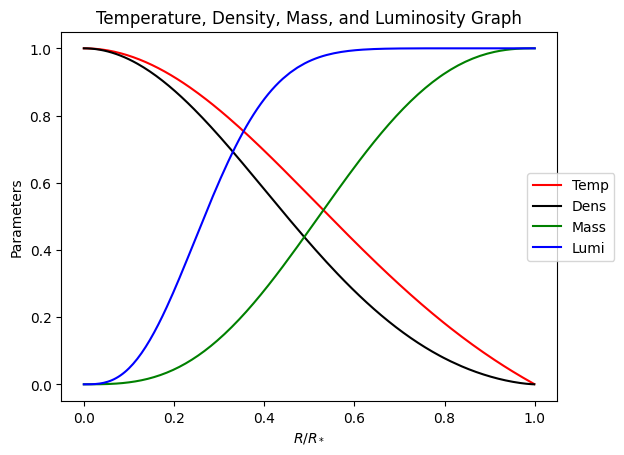

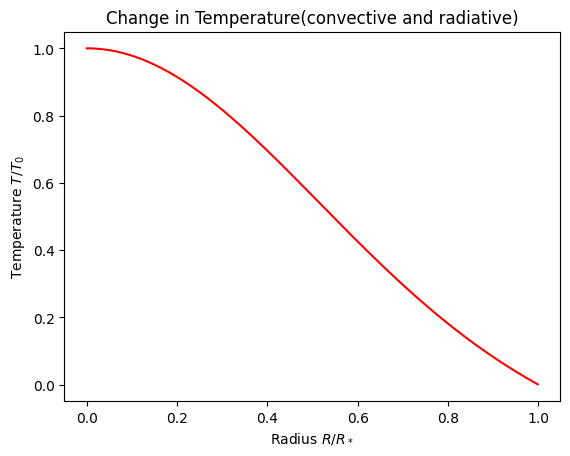

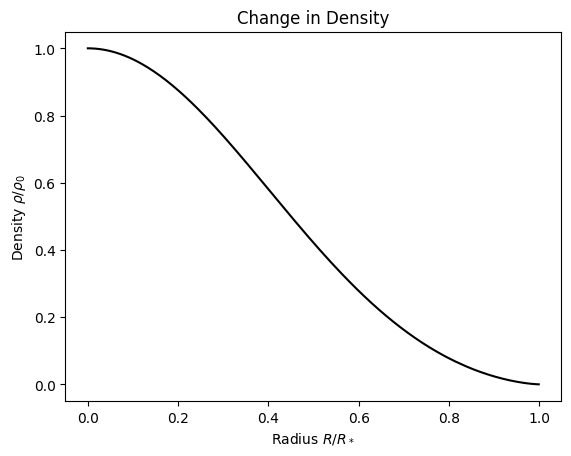

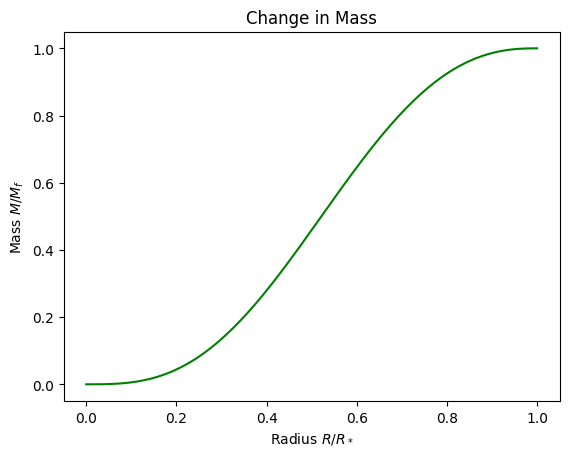

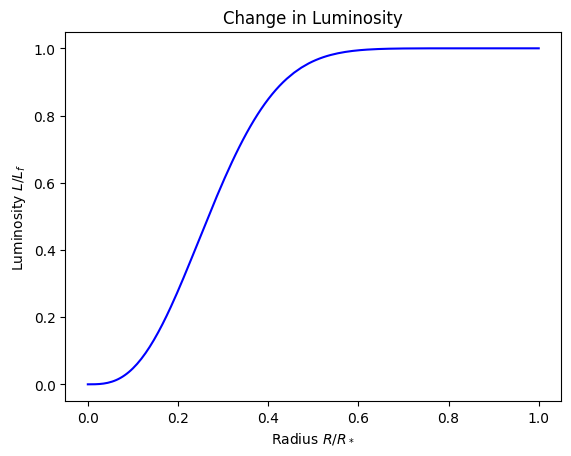

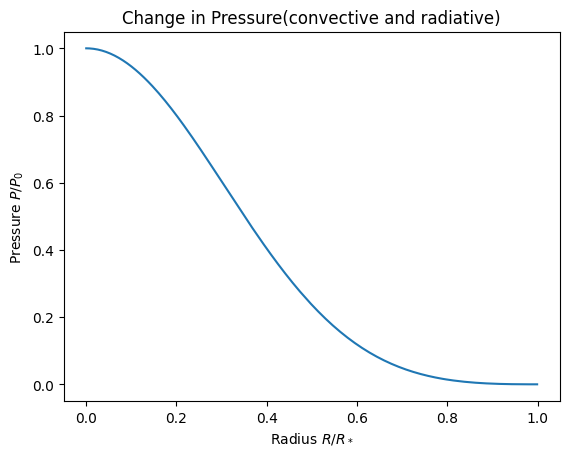

In [6]:
def Plots(test):
    #Combonation Plot;
    plt.figure("Temp, Mass, Lumi, Dens")
    plt.plot(np.array(test.radius)/test.radius[-1], np.array(test.temperature)/test.temperature[0], 'r-', label = "Temp")
    plt.plot(np.array(test.radius)/test.radius[-1], np.array(test.density)/test.density[0]        , 'k-', label = "Dens")
    plt.plot(np.array(test.radius)/test.radius[-1], np.array(test.mass)/test.mass[-2]             , 'g-', label = "Mass")
    plt.plot(np.array(test.radius)/test.radius[-1], np.array(test.luminosity)/test.luminosity[-2] , 'b-', label = "Lumi")
    plt.xlabel("$R/R_*$")
    plt.ylabel('Parameters')
    plt.title("Temperature, Density, Mass, and Luminosity Graph")
    plt.legend(bbox_to_anchor=(1, 0.6), bbox_transform=plt.gcf().transFigure)
    
    #Temperature Plot;
    plt.figure("Temperature")
    plt.plot  (np.array(test.radius)/test.radius[-1], np.array(test.temperature)/test.temperature[0], 'r-')
    plt.xlabel("Radius $R/R_*$")
    plt.ylabel("Temperature $T/T_0$")
    plt.title("Change in Temperature(convective and radiative)")

    #Density Plot;
    plt.figure("Density")
    plt.plot  (np.array(test.radius)/test.radius[-1], np.array(test.density)/test.density[0], 'k-')
    plt.xlabel("Radius $R/R_*$")
    plt.ylabel("Density $\\rho/\\rho_0$")
    plt.title("Change in Density")

    #Mass Plot;
    plt.figure("Mass")
    plt.plot  (np.array(test.radius)/test.radius[-1], np.array(test.mass)/test.mass[-2], 'g-')
    plt.xlabel("Radius $R/R_*$")
    plt.ylabel("Mass $M/M_f$")
    plt.title("Change in Mass")

    #Luminosity Plot;
    plt.figure("Luminosity")
    plt.plot  (np.array(test.radius)/test.radius[-1], np.array(test.luminosity)/test.luminosity[-2], 'b-')
    plt.xlabel("Radius $R/R_*$")
    plt.ylabel("Luminosity $L/L_f$")
    plt.title("Change in Luminosity")

    #Pressure Plot;
    plt.figure("Pressure")
    plt.plot  (np.array(test.radius)/test.radius[-1], np.array(test.pressure)/test.pressure[0])
    plt.xlabel("Radius $R/R_*$")
    plt.ylabel("Pressure $P/P_0$")
    plt.title("Change in Pressure(convective and radiative)")
    #plt.xlim([0,0.15])
    plt.show()

test1 = Hydrostatic_STAR(100.0e3, rho_c, T_c)

Plots(test1)

PART 7: The final part; I couldn't figure out how to get multiple final parameters for many stars with varying central densities and temperatures and plot them through an individual function - I could have done it manually but even for 10 points to do 10 points manually is a lot in itself and nowhere near illuminating enough to indicate how accurate is could model the HRD; instead, I decided to look at the distributions of the parameters; from part 6, the trends are not surprising, perhaps, what is more surprising it my mass the functions increase or decrease exponentially and how does the look physically.

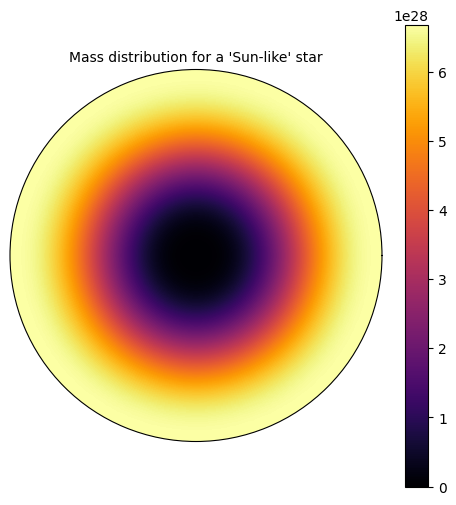

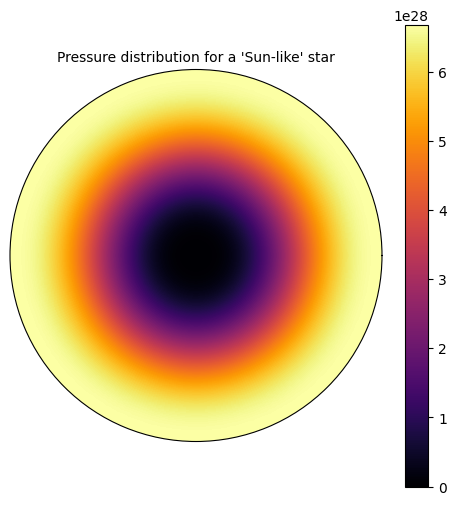

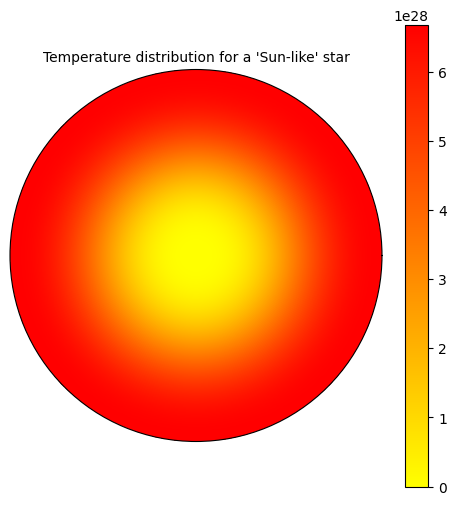

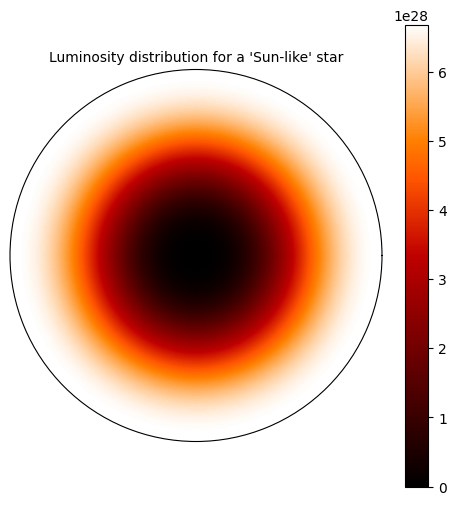

None


In [ ]:
def distribution_plots_1(test):
    R = test.radius[-1]
    y = np.linspace(0, R, 1000)  # radial points
    theta = np.linspace(0, 2 * np.pi, 360)  # angle points
    t, r = np.meshgrid(theta, y)

    def interp_safe(y, x, values, name):
        if len(x) < 2:
            raise ValueError(f"Not enough data to interpolate {name}")
        return np.interp(y, x, values)

    try:
        mass_interp = interp_safe(y, test.radius, test.mass, "mass")
        pres_interp = interp_safe(y, test.radius, test.pressure, "pressure")
        temp_interp = interp_safe(y, test.radius, test.temperature, "temperature")
        lumi_interp = interp_safe(y, test.radius, test.luminosity, "luminosity")

    except ValueError as e:
        print(e)
        return

    #Tile interpolated data over angular dimension
    zm = np.tile(mass_interp[:, None], (1, len(theta)))
    zp = np.tile(mass_interp[:, None], (1, len(theta)))
    zt = np.tile(mass_interp[:, None], (1, len(theta)))
    zl = np.tile(mass_interp[:, None], (1, len(theta)))

    for data, title, cmap in zip(
        [zm, zp, zt, zl],
        ["Mass", "Pressure", "Temperature", "Luminosity"],
        ['inferno', 'inferno', 'autumn_r', 'gist_heat']
    ):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(projection='polar')
        c = ax.pcolormesh(t, r, data, cmap=cmap, shading='auto')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        fig.colorbar(c, ax=ax)
        ax.set_title(f"{title} distribution for a 'Sun-like' star", fontsize=10)
        plt.show()

print(distribution_plots_1(test1))